# Exercise 6

## 1 Bias and variance of ridge regression

<div style="color:green; font-weight: bold">
Does differ quite a bit from the sample solution but seems to be correct.
</div>

Show that
$$ \mathbb{E} [\hat{\beta}_\tau] = S_\tau^{-1}S \beta^* \quad \text{and} \quad \text{Cov}[\hat{\beta}_\tau] = S^{-1}_\tau S S^{-1}_\tau \sigma^2 \quad \text{with} \quad S=X^TX, \quad S_\tau = X^TX+\tau \mathbb{1}_D$$
First, we write the ridge estimator as follows: 
$$ \hat{\beta}_\tau = ( X^TX+\tau \mathbb{1}_D)^{-1}X^Ty \\
= (X^TX+\tau \mathbb{1}_D)^{-1}X^T(X\beta + \epsilon) \\
= (X^TX+\tau \mathbb{1}_D)^{-1}X^TX \beta^* + (X^TX+\tau \mathbb{1}_D)^{-1}X^T\epsilon$$
We then calculate the expectation value 
$$ \mathbb{E}[\hat{\beta}_\tau] = (X^TX+\tau \mathbb{1}_D)^{-1}X^TX \beta + (X^TX+\tau \mathbb{1}_D)^{-1})X^T \mathbb{E}[\epsilon] \\
= (X^TX +\tau \mathbb{1}_D)^{-1}X^TX \beta^* + (X^TX+\tau \mathbb{1}_D)^{-1})X^T \cdot 0 \\
= (X^TX +\tau \mathbb{1}_D)^{-1}X^TX \beta^* \\
= S_\tau^{-1}S\beta^*$$
To calculate the variance, we can write the ridge estimator as a function of the OLS estimator 
$$\hat{\beta}_\tau = (X^TX+\tau \mathbb{1}_D)^{-1}X^Ty \\
= (X^TX + \tau \mathbb{1}_D)^{-1}X^TX(X^TX)^{-1}X^Ty \\
= (X^TX + \tau \mathbb{1}_D)^{-1}X^TX \hat{\beta}$$
Then the variance becomes
$$\text{Cov}[\hat{\beta}_\tau]=(X^TX + \tau \mathbb{1}_D)^{-1}X^TX \, \text{Cov}[\hat{\beta}_\tau]\, [(X^TX + \tau \mathbb{1}_D)^{-1}X^TX]^T\\
=(X^TX + \tau \mathbb{1}_D)^{-1}X^TX \, \text{Cov}[\hat{\beta}_\tau]\, X^TX(X^TX + \tau \mathbb{1}_D)^{-1}\\
=(X^TX + \tau \mathbb{1}_D)^{-1}X^TX \sigma^2(X^TX)^{-1}X^TX(X^TX + \tau \mathbb{1}_D)^{-1} \\
= (X^TX + \tau \mathbb{1}_D)^{-1}X^TX (X^TX + \tau \mathbb{1}_D)^{-1} \sigma^2 \\
= S_\tau^{-1}SS_\tau^{-1}\sigma^2$$

## 2 Denoising of a CT image

<div style="color:green; font-weight: bold">
Use of tau instead of sqrt(tau)
</div>

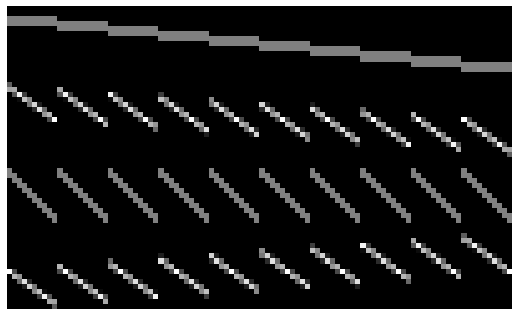

Shape: 6976 x 5929
Sparsity: 98.17 %



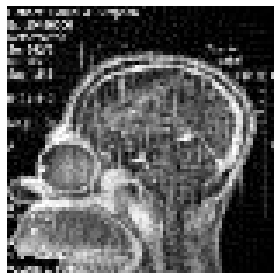

Shape: 17600 x 38025
Sparsity: 99.27 %



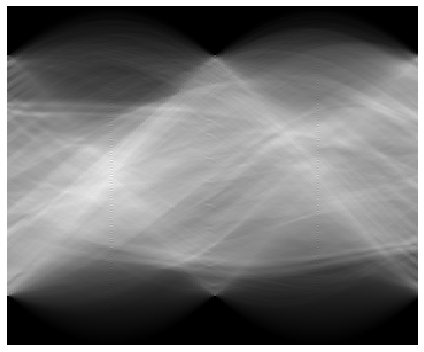

Ridge regression with tau = 1, 10, 100, 1000, 10000


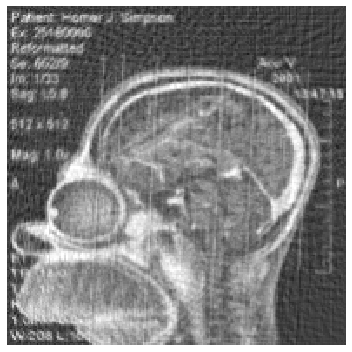

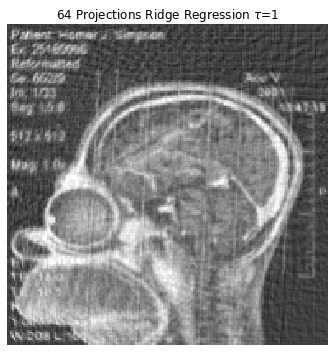

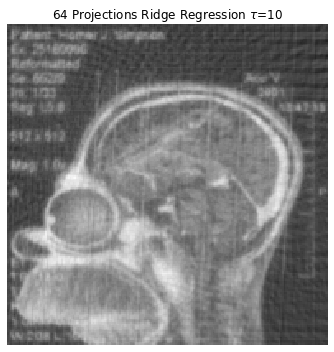

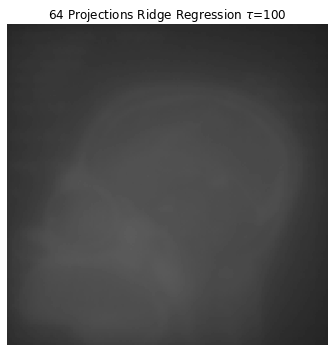

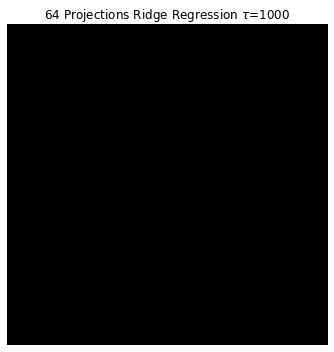

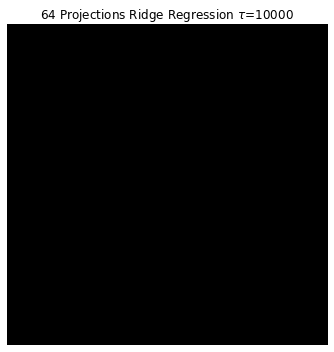

Gaussian filter with sigma = 1, 2, 3, 5, 7


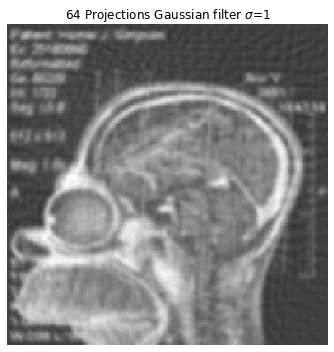

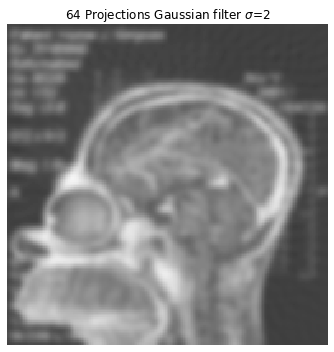

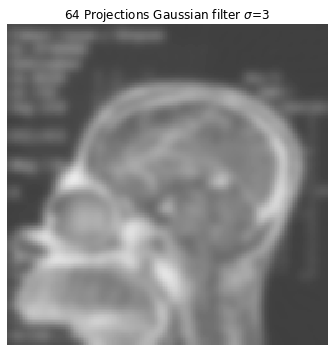

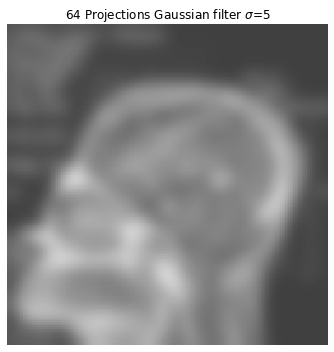

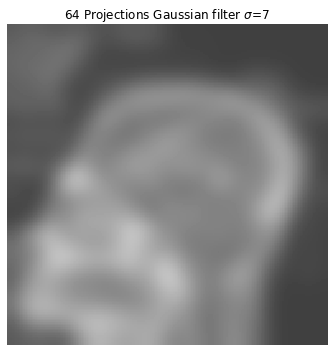

In [22]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import dok_matrix, coo_matrix, vstack, diags
from scipy.sparse.linalg import lsqr
from scipy.ndimage import gaussian_filter

from sklearn.datasets import load_digits
from sklearn.model_selection  import train_test_split
from sklearn import linear_model
import matplotlib as mpl

def construct_X(M, alphas, Np = None, tau=0):
    D = M*M
    # define sensor size
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
        if Np % 2 == 0: Np += 1
    # number of angles
    No = len(alphas)
    
    # flattened output coordinates
    j = np.mgrid[0:D].astype(np.int32)
    # coordinate matrix for the output pixels
    M2 = (M-1) / 2
    grid = np.mgrid[-M2:M-M2,-M2:M-M2].swapaxes(1,2).reshape(2,D)
    
    # collect indices and corresponding values for all iterations
    i_indices = []
    j_indices = []
    weights = []
    
    for k, alpha in enumerate(alphas):
        # convert angle and prepare projection vector
        alph_rad = np.radians(alpha)
        proj_vec = np.array([np.cos(alph_rad), -np.sin(alph_rad)])
        # project coordinates
        proj = np.dot(proj_vec, grid) + Np // 2
        # compute sensor indices and weights below the projected points
        i = np.floor(proj)
        w = (i+1) - proj

        # make sure rays falling outside the sensor are not counted
        clip = np.logical_and(0 <= i, i < Np-1)

        i_indices.append((i + k*Np)[clip])
        j_indices.append(j[clip])
        weights.append(w[clip])
        # compute sensor indices and weights above the projected points
        w = proj - i
        i_indices.append((i+1 + k*Np)[clip])
        j_indices.append(j[clip])
        weights.append(w[clip])

    # construct matrix X
    i = np.concatenate(i_indices).astype(np.int32)
    j = np.concatenate(j_indices).astype(np.int32)
    w = np.concatenate(weights)
    X = coo_matrix((w, (i,j)), shape = (No*Np, D), dtype = np.float32)

    if tau > 0:
        tau_matrix = diags(np.ones(X.shape[1]))*tau
        X = vstack([X, tau_matrix])

    return X

def reduce_projections(n,Np,alphas, y):
    # pick specified number of angles
    index = [int(np.ceil(len(alphas) * p/n)) for p in range(n)]
    alphas_red = alphas[index]
    
    # collect corresponding measurements from y
    y_red = []
    for i in index:
        y_red.extend(y[i*Np : (i+1)*Np])
    return alphas_red, np.array(y_red)


# check correctness
a = [-90,-45,0,45]
X = construct_X(10, a, tau=0)

fig = plt.figure(figsize = (10, 4.5))
plt.imshow(X.toarray(), interpolation = 'nearest')
plt.gray(); plt.axis('off'); fig.tight_layout(); plt.show()
plt.show()


# small example with 77x77 image
# sensor size = ceil(sqrt(77*77 + 77*77)) = 109
# measurements are 109 sensor pixels times 90 angles
y_small = np.load('hs_tomography/y_77.npy')
alphas_small = np.load('hs_tomography/alphas_77.npy')

#reduce projections
alphas_small, y_small = reduce_projections(64, 109,alphas_small, y_small)

X_small = construct_X(77, alphas_small, 109).tocsc()
# np.save('hs_tomography/X_77', X_small)

print('Shape:', X_small.shape[0], 'x', X_small.shape[1])
print('Sparsity:', round(100 * (1 - X_small.nnz / np.prod(X_small.shape)), 2), '%\n')


beta_small = lsqr(X_small, np.array(y_small), atol = 1e-5, btol = 1e-5)[0].reshape(77,77)

fig = plt.figure(figsize = (4,4))
plt.imshow(beta_small, vmin = 0, vmax = 255, interpolation = 'nearest')
plt.gray(); plt.axis('off'); fig.tight_layout(); plt.show()

# big example with 195x195 image
# sensor size = floor(sqrt(195*195 + 195*195)) = 275
# measurements are 275 sensor pixels times 90 angles
y = np.load('hs_tomography/y_195.npy')
alphas = np.load('hs_tomography/alphas_195.npy')

#reduce projections
alphas, y = reduce_projections(64, 275,alphas, y)

X = construct_X(195, alphas, 275).tocsc()

print('Shape:', X.shape[0], 'x', X.shape[1])
print('Sparsity:', round(100 * (1 - X.nnz / np.prod(X.shape)), 2), '%\n')

fig = plt.figure(figsize = (6,5))
plt.imshow(np.load('hs_tomography/y_195.npy').reshape(179,275).T, interpolation = 'nearest', aspect = 'auto')
plt.gray(); plt.axis('off'); fig.tight_layout(); plt.show()

beta_0 = lsqr(X, np.array(y), atol = 1e-5, btol = 1e-5)[0].reshape(195,195)

fig = plt.figure(figsize = (5,5))
plt.imshow(beta_0, vmin = 0, vmax = 255, interpolation = 'nearest')
plt.gray(); plt.axis('off'); fig.tight_layout()#; plt.show()

print("Ridge regression with tau = 1, 10, 100, 1000, 10000")
for i in [1, 10, 100, 1000, 10000]:
    X = construct_X(195, alphas, 275, tau=i).tocsc()
    y_ = np.concatenate([y, np.zeros(int(X.shape[0]-y.shape[0]))])
    beta = lsqr(X, y_, atol = 1e-5, btol = 1e-5)[0].reshape(195,195)
    fig = plt.figure(figsize = (5,5))
    plt.imshow(beta, vmin = 0, vmax = 255, interpolation = 'nearest')
    plt.title(r"64 Projections Ridge Regression $\tau$=" + str(i))
    plt.gray(); plt.axis('off'); fig.tight_layout()

plt.show()

print("Gaussian filter with sigma = 1, 2, 3, 5, 7")
for i in [1, 2, 3, 5, 7]:
    beta_blur = gaussian_filter(beta_0, i)
    fig = plt.figure(figsize = (5,5))
    plt.imshow(beta_blur, vmin = 0, vmax = 255, interpolation = 'nearest')
    plt.title(r"64 Projections Gaussian filter $\sigma$=" + str(i))
    plt.gray(); plt.axis('off'); fig.tight_layout()

plt.show()



We can see that while the Gaussian filter retains contrasts better, for large Gaussian sigmas, the ridge regression retains more detail even at high taus, at the cost of some contrast. As we can see, the ridge regression has a higher bias and lower variance in comparison to the Gaussian filter, that introduces a higher variance but has a lower bias.

## 3 Automatic feature selection for regression
### 3.1 Implement Orthogonal Matching Pursuit 

<div style="color:green; font-weight: bold">
Does not apply abs to j
</div>

In [6]:
def omp_regression(X, y, T):
    A = []
    B = [x for x in range(X.shape[0])]
    r = y

    arr_beta = np.zeros([T, X.shape[0]])

    for t in range(T):
        j = np.argmax(np.dot(X[B], r))
        if j in B:
            A.append(j)
            B.remove(j)
    
        X_t = X[A].T
        regression = linear_model.LinearRegression()
        regression.fit(X_t, y)
        beta = regression.coef_

        r = y-np.dot(X[A].T, beta)

        for idx, b in zip(A, beta):
            arr_beta[t, idx] = b
    
    return arr_beta

### 3.2 Classification with sparse LDA

<div style="color:green; font-weight: bold">
Seems good
</div>

Plot of regression procedure


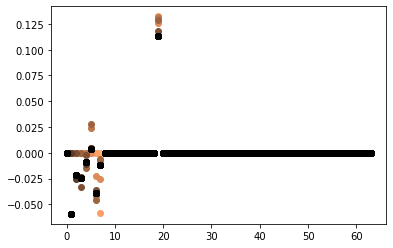

Plot of predicted Y distribution (OMP)


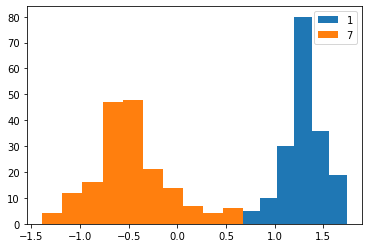

Plot of predicted Y distribution with random picture as beta


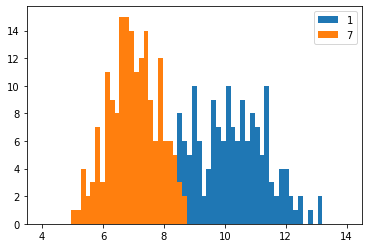

In [21]:
digits = load_digits()

data = digits['data']
images = digits['images']
target = digits['target']
target_names = digits['target_names']

x_all = data
y_all = target

idx_a = np.where(y_all == 1)
idx_b = np.where(y_all == 7)

x_a = x_all[idx_a]
y_a = y_all[idx_a]
x_b = x_all[idx_b]
y_b = y_all[idx_b]*0-1
#y_b = np.full(len(idx_b), -1)

x_ab = np.concatenate([x_a, x_b], axis=0)
y_ab = np.concatenate([y_a, y_b], axis=0) 

betas = omp_regression(x_ab.T, y_ab, 20)

print("Plot of regression procedure")
plt.figure()
for i, b in enumerate(betas):
    #plt.subplot(511+i)
    #plt.ylim((-0.1, 0.5))
    plt.scatter(np.arange(64), b, color=mpl.cm.copper(1-i/10))
plt.show()

print("Plot of predicted Y distribution (OMP)")
bins = None
plt.figure()
plt.hist(np.dot(x_a, betas[-1]), bins, label="1")
plt.hist(np.dot(x_b, betas[-1]), bins, label="7")
plt.legend(loc='best')
plt.show()

f1 = x_ab[60]
f1 /= np.sum(f1)

print("Plot of predicted Y distribution with random picture as beta")
bins = np.linspace(4, 14, 64)
plt.figure()
plt.hist(np.dot(x_a, f1), bins, label="1")
plt.hist(np.dot(x_b, f1), bins, label="7")
plt.legend(loc='best')
plt.show()

We can see that OMP seperates better than our previous method for feature selection.

<div style="color:green; font-weight: bold">
3.3 missing
</div>